# Testing wide-gap simulations
I here use [Goodman & Ji (2002)](http://adsabs.harvard.edu/abs/2002JFM...462..365G) as a test case for wide-gap simulations. I want to reproduce their figure 3 showing the nasty boundary layers in low Pm flow.

For simplicity, I'll just use dimensional variables:

$r_{in} = 5\ \mathrm{cm}$ 

$r_{out} = 15\ \mathrm{cm}$ 

$h = 10\ \mathrm{cm}$ 

$\rho = 6\ \mathrm{g/cm^3}$

$\eta = 2000\ \mathrm{cm^2/s}$

$\mathrm{Pm} = 1.6 \times 10^{-6}$

$\nu = \eta \mathrm{Pm} = 3.26 \times 10^{-3}\ \mathrm{cm^2/s}$

In [1]:
1.63e-6*2000

0.0032600000000000003

In [2]:
%matplotlib nbagg

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

In [4]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [5]:
nr = 256

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

Just to make sure our parameters are right, we compute $\bar{\zeta}$ as they do. Oddly, it's only the same to one digit of precision. Not sure what the deal is with that.

In [6]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 313.55 # rad/s
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487258.5449548315; Re_out = 58896.823006819046
zeta bar = 0.06318130680011043


In [7]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r],grid_dtype=np.double)

In [8]:
r_g = r.grid()

In [9]:
B = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
A = Omega_in - B/r_in**2

Omega = A + B/r_g**2

In [10]:
omega = domain.new_field()
vorticity = domain.new_field()
r2_omega = domain.new_field()

We'll use a one-dimensional formulation, in which the flow variables have sin/cos dependence in $z$: $u(r,z,t) = \hat{u}(r,t) \sin (kz)$. Note they use the opposite parity (velocities $(u,v,w) \propto (\sin(kz),\sin(kz),\cos(kz))$ from Chandrasekhar's book for reasons known only to Jeremy. This makes $z = 0$ the center of the tank instead of the bottom.

We write everything in terms of a single wavemode, $k = \pi/h$, where $h$ is the height of the tank.

In [11]:
variables = ['u','v','w','Br','Bphi','Bz','p','vr','wr','Bphi_r']
gmri = de.IVP(domain,variables)
gmri.parameters['nu'] = nu
gmri.parameters['eta'] = eta
gmri.parameters['rho'] = rho
gmri.parameters['u0'] = 1
gmri.parameters['u0r'] = 1
gmri.parameters['B0'] = B0
gmri.parameters['pi'] = np.pi
gmri.parameters['k'] = np.pi/h
gmri.parameters['A'] = A
gmri.parameters['B'] = B
gmri.substitutions['ru0'] = '(r*r*A + B)' # u0 = r Omega(r) = Ar + B/r
gmri.substitutions['rrdu0'] = 'A*r*r-B' # du0/dr = A - B/r^2

In [12]:
gmri.add_equation("r**2*dt(u) - nu*r**2*(-k**2*u + k*wr)  + r**2*dr(p)/rho - 2*ru0*v + r**2*B0*k*Br/(4*pi*rho) = 0")
gmri.add_equation("r**2*dt(v) - nu*(r**2*dr(vr) + r*vr - r**2*k**2*v - v) + ru0*u + u*rrdu0 + r**2*B0*k*Bphi/(4*pi*rho) = 0")
gmri.add_equation("r*dt(w) - nu*(r*dr(wr) + wr - r*k**2*w) + r*k*p/rho - r*B0*k*Bz/(4*pi*rho) = 0")
gmri.add_equation("r*dr(u) + u - r*k*w = 0")
gmri.add_equation("vr - dr(v) = 0")
gmri.add_equation("wr - dr(w) = 0")
gmri.add_equation("dt(Br) - eta*(-k**2*Br - k*dr(Bz)) - B0*k*u = 0")
gmri.add_equation("r**2*dt(Bphi) - eta*(r**2*dr(Bphi_r) - r**2*k**2*Bphi + r*Bphi_r - Bphi) - Br*rrdu0 + ru0*Br - r**2*B0*k*v = 0")
gmri.add_equation("r*dr(Br) + Br + r*k*Bz = 0")
gmri.add_equation("Bphi_r - dr(Bphi) = 0")

In [13]:
# boundary conditions
gmri.add_bc("left(u) = 0")
gmri.add_bc("left(v) = 0")
gmri.add_bc("left(w) = 0")
gmri.add_bc("right(u) = 0")
gmri.add_bc("right(v) = 0")
gmri.add_bc("right(w) = 0")
gmri.add_bc("left(Br) = 0")
gmri.add_bc("right(Br) = 0")
gmri.add_bc("left(dr(r*Bphi)) = 0")
gmri.add_bc("right(dr(r*Bphi)) = 0")

They don't give the growth rate of the run they use to show the eigenmodes (of course!). A rough guess from the growth rates they give in their table 1 shows that for conducting boundaries and a 3 kG field, $\gamma = 21.13 \mathrm{s}^{-1}$. Given that the period of the inner cylinder is $2\pi/\Omega_{in} \simeq 0.02 \mathrm{s}$, to get to one e-folding is about a thousand rotation periods or so. We'll set the stop time at 2000 periods. 

In [14]:
dt = max_dt = 1.
period = 2*np.pi/Omega_in

ts = de.timesteppers.RK443
IVP = gmri.build_solver(ts)
IVP.stop_sim_time = 2000.*period
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 500#00000

2016-05-06 12:32:02,475 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+00/s


In [15]:
print(period)

0.02003886240529289


In [16]:
phi = domain.new_field(name='phi')
phi_z = domain.new_field(name='phi_z')

In [17]:
p = IVP.state['p']
u = IVP.state['u']
v = IVP.state['v']
w = IVP.state['w']
vr = IVP.state['vr']
wr = IVP.state['wr']
Br = IVP.state['Br']
Bphi = IVP.state['Bphi']
Bz = IVP.state['Bz']
for f in [phi,p,u,v,w,vr,wr]:
    f.set_scales(domain.dealias, keep_data=False)

Now, we'll set the ICs by creating a velocity potential $\psi$.

In [18]:
# incompressible perturbation, arbitrary vorticity
k = gmri.parameters['k']

phi['g'] = 1e-3*np.random.randn(*v['g'].shape)*np.sin(np.pi*(r_g - r_in))
phi['c'][nr/3:] = 0
phi.differentiate(0,out=w)
w['g'] += phi['g']/r_g
#w['g'] *= np.sin(np.pi*(r_g - r_in))
w.differentiate(0,out=wr)
u['g'] = k*phi['g']#*np.sin(np.pi*(r_g - r_in))

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Double check that $\nabla \cdot \mathbf{u} = 0$ to machine precision

In [19]:
divu0 = domain.new_field(name='divu0')

u.differentiate(0,out=divu0)
divu0['g'] += u['g']/r_g - k*w['g']

<IPython.core.display.Javascript object>


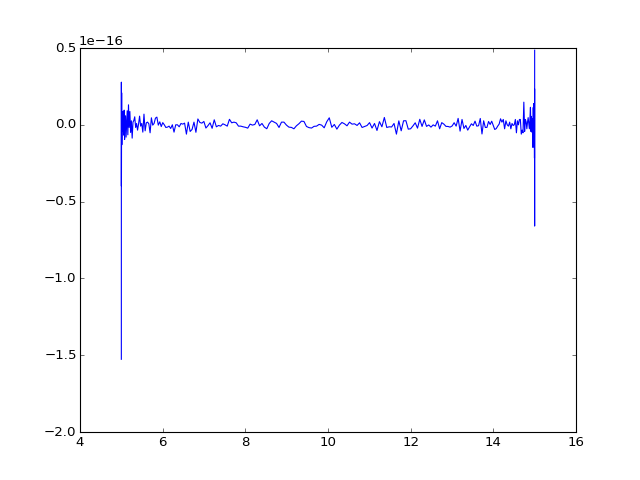

In [20]:
plt.figure()
plt.plot(r_g,divu0['g'])

In [21]:
CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
                     max_change=1.5, min_change=0.5)
CFL.add_velocities(('u'))

In [22]:
# Integrated energy every 10 iterations
analysis1 = IVP.evaluator.add_file_handler("scalar_data", iter=10)
analysis1.add_task("integ(0.5 * (u*u + v*v + w*w))", name="total kinetic energy")
analysis1.add_task("integ(0.5 * (u*u + w*w))", name="meridional kinetic energy")
analysis1.add_task("integ((u*u)**0.5)", name='u_rms')
analysis1.add_task("integ((w*w)**0.5)", name='w_rms')

# Snapshots every half an inner rotation period
analysis2 = IVP.evaluator.add_file_handler('snapshots',sim_dt=0.5*period, max_size=2**30)
analysis2.add_system(IVP.state, layout='g')

In [23]:
dt = CFL.compute_dt()
# Main loop
start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    if IVP.iteration % 10 == 0:
        logger.info('Iteration: %i, Inner Cylinder Rev: %e, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time/period,IVP.sim_time, dt))
    dt = CFL.compute_dt()


end_time = time.time()

# Print statistics
logger.info('Total time: %f sec' %(end_time-start_time))
logger.info('Iterations: %i' %IVP.iteration)

2016-05-06 12:32:04,167 __main__ 0/1 INFO :: Iteration: 10, Inner Cylinder Rev: 8.733031e-01, Time: 1.750000e-02, dt: 2.250000e-03
2016-05-06 12:32:05,504 __main__ 0/1 INFO :: Iteration: 20, Inner Cylinder Rev: 2.838235e+00, Time: 5.687500e-02, dt: 5.062500e-03
2016-05-06 12:32:06,799 __main__ 0/1 INFO :: Iteration: 30, Inner Cylinder Rev: 7.259332e+00, Time: 1.454687e-01, dt: 1.139063e-02
2016-05-06 12:32:08,108 __main__ 0/1 INFO :: Iteration: 40, Inner Cylinder Rev: 1.720680e+01, Time: 3.448047e-01, dt: 2.562891e-02
2016-05-06 12:32:09,356 __main__ 0/1 INFO :: Iteration: 50, Inner Cylinder Rev: 3.958860e+01, Time: 7.933105e-01, dt: 5.766504e-02
2016-05-06 12:32:10,722 __main__ 0/1 INFO :: Iteration: 60, Inner Cylinder Rev: 8.994766e+01, Time: 1.802449e+00, dt: 1.297463e-01
2016-05-06 12:32:12,094 __main__ 0/1 INFO :: Iteration: 70, Inner Cylinder Rev: 2.032555e+02, Time: 4.073010e+00, dt: 2.919293e-01
2016-05-06 12:32:13,374 __main__ 0/1 INFO :: Iteration: 80, Inner Cylinder Rev: 4.5

In [24]:
print("sec per step = {0:8.4f}".format((end_time - start_time)/IVP.iteration))

sec per step =   0.1333


In [25]:
z_g = domain.grid(0)

Since these are linear eigenfunctions, we can scale them such that they match Goodman & Ji (2002)'s figure 2 (JFM version)/figure 3 (arxiv version). Note that you'll have to do the sign by hand here...if it looks funny, fix the sign.

In [26]:
scale_factor = 2.7/np.abs(v['g']).max()
#scale_factor = 2.7/v['g'].max()
#print(np.abs(v['g']).max())
#print(np.abs(v['g']))

<IPython.core.display.Javascript object>


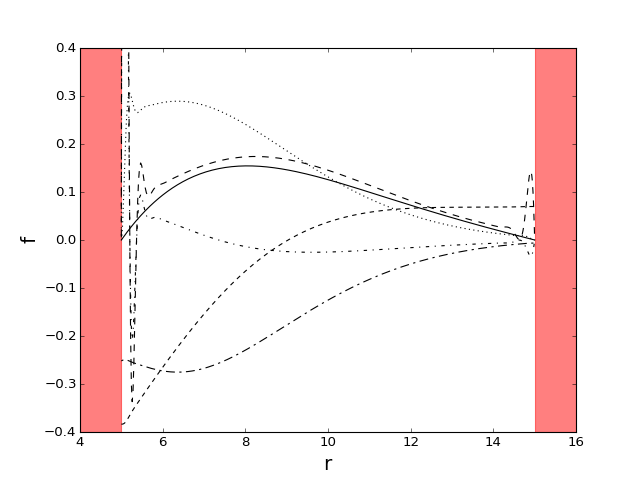

(-0.4, 0.4)

In [27]:
plt.figure()
plt.plot(z_g,scale_factor*v['g'],'k',ls='--')
plt.plot(z_g,scale_factor*u['g']/3.,'k',ls='dotted')
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.')
plt.plot(z_g,scale_factor*Br['g']/np.sqrt(4*np.pi*rho),'k')
plt.plot(z_g,scale_factor*Bphi['g']/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(z_g,scale_factor*Bz['g']/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
plt.ylim(-0.4,0.4)

Now, we do the closeup (right panel of their figure). Things look quite good.

<IPython.core.display.Javascript object>


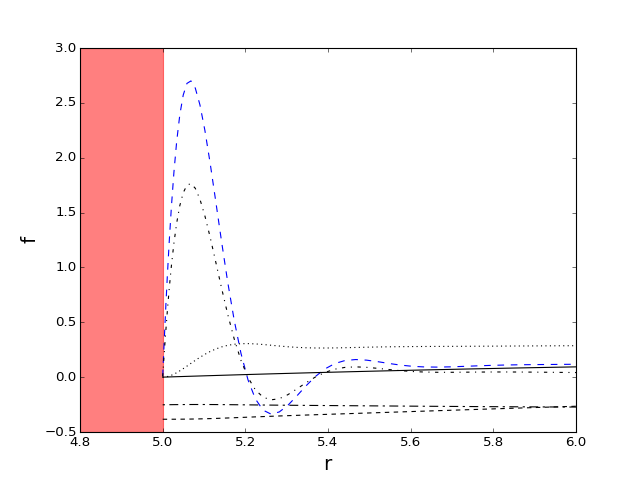

(-0.5, 3)

In [28]:
plt.figure()
plt.plot(z_g,scale_factor*v['g'],'b',ls='--')
plt.plot(z_g,scale_factor*u['g']/3,'k',ls='dotted')
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.')
plt.plot(z_g,scale_factor*Br['g']/np.sqrt(4*np.pi*rho),'k')
plt.plot(z_g,scale_factor*Bphi['g']/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(z_g,scale_factor*Bz['g']/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4.8, 5, alpha=0.5, color='red')

plt.xlim(4.8,6)
plt.ylim(-0.5,3)

Now, we check the growth rate.

In [29]:
def get_timeseries(data, field):
    data_1d = []
    time = data['scales/sim_time'][:]
    data_out = data['tasks/%s'%field][:,0]
    return time, data_out

In [30]:
data = h5py.File("scalar_data/scalar_data_s1/scalar_data_s1_p0.h5", "r")
t, ke = get_timeseries(data, 'total kinetic energy')
t, kem = get_timeseries(data, 'meridional kinetic energy')
t, urms = get_timeseries(data, 'u_rms')
t, wrms = get_timeseries(data, 'w_rms')

<IPython.core.display.Javascript object>


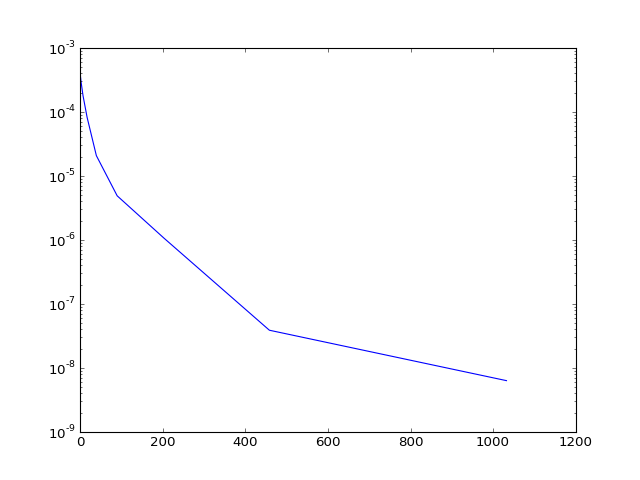

In [31]:
plt.figure()
plt.semilogy(t/period,ke)

<IPython.core.display.Javascript object>


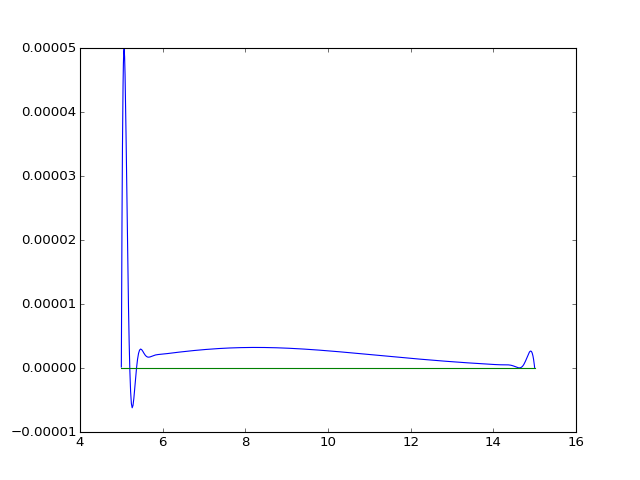

In [36]:
fig = plt.figure()
plt.plot(r_g, v['g'].real)
plt.plot(r_g, v['g'].imag)